In [2]:
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt

In [3]:
data = []
label = []
path = "../1_Fetal_gradcams/clustering_cats_dogs/train/train/"
c = 0
d = 0
IMG_SIZE = 256
for file in os.listdir(path):
    img=cv2.imread(path+file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    img=img.astype('uint8')
    if file[:3]=='cat':
        if c==500: continue
        c+=1
        label.append("cat")
    else:
        if d==500: continue
        d+=1
        label.append("dog")
    data.append(img)
data = np.array(data)

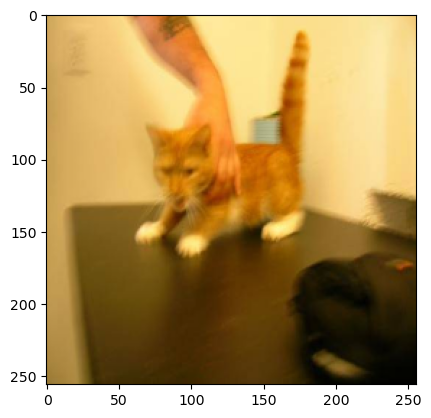

In [4]:
plt.imshow(data[0])

In [5]:
data.shape

(1000, 256, 256, 3)

In [6]:
data_label = []
for i in label:
    if i=="cat": data_label.append(0)
    else: data_label.append(1)
data_label = np.array(data_label)

## Method 1 - Transfer Learning

In [6]:
from keras.applications.resnet import preprocess_input
import keras.utils as image
import keras

In [78]:
model =   keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))

In [79]:
def extract_vector(data_holder):

    resnet_feature_list = []

    for im in data_holder:

        im = image.img_to_array(im) 

        img = preprocess_input(np.expand_dims(im.copy(), axis=0))

        resnet_feature = model.predict(img)

        resnet_feature_np = np.array(resnet_feature)

        resnet_feature_list.append(resnet_feature_np.flatten())
    return np.array(resnet_feature_list)

In [80]:
array = extract_vector(data)
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(array)

1/1 [==============================] - 0s 32ms/step


c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [81]:
# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label
# Mapping predictions to original labels
def get_labels(clusters,refernce_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

In [82]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)

In [83]:
print(accuracy_score(predicted_labels,data_label))

0.949


In [84]:
from sklearn.metrics.cluster import adjusted_rand_score
print("Adjusted rand-score: ", adjusted_rand_score(predicted_labels, data_label))

Adjusted rand-score:  0.8062118809029016


## Method 2 - CNN classifier 

In [7]:
import tensorflow as tf

In [8]:
model=tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3),
    pooling=None,
)

In [9]:
# freeze pre-trained layers
for layer in model.layers:
    layer.trainable = False

model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 


                                                                                                  
 conv1/bn (BatchNormalization)  (None, 128, 128, 64  256         ['conv1/conv[0][0]']             
                                )                                                                 
                                                                                                  
 conv1/relu (Activation)        (None, 128, 128, 64  0           ['conv1/bn[0][0]']               
                                )                                                                 
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 130, 130, 64  0          ['conv1/relu[0][0]']             
 D)                             )                                                                 
                                                                                                  
 pool1 (Ma

In [10]:
d1=tf.keras.layers.Dense(2, activation='softmax')(tf.keras.layers.GlobalMaxPooling2D()(model.output))
densenet=tf.keras.models.Model(inputs=model.input,outputs=d1)

In [11]:
densenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [12]:
densenet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [13]:
batch_size = 8
from sklearn.model_selection import train_test_split as tts
X_train, X_holdout, y_train, y_holdout = tts(data, data_label, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = tts(X_holdout, y_holdout, test_size=0.5, random_state=42)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(800, 256, 256, 3) (800,)
(100, 256, 256, 3) (100,)
(100, 256, 256, 3) (100,)


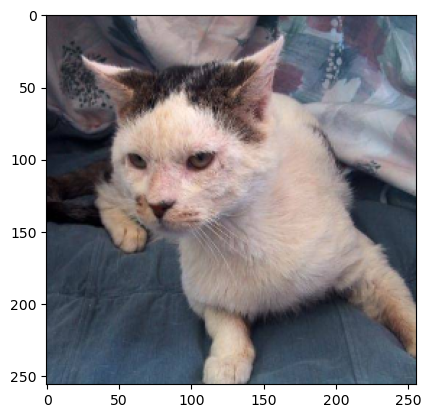

In [15]:
plt.imshow(X_train[0])

In [16]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [17]:
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

In [24]:
from tensorflow.keras.models import load_model

# Load the saved model
densenet = load_model('1_cat_dog_clustering_TL_model_1.h5')


In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#n_classes=3
n_steps = X_train.shape[0] // batch_size
n_val_steps = X_val.shape[0] // batch_size
n_epochs = 20
# EarlyStopping
early_stop = EarlyStopping(monitor='loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = densenet.fit(X_train, y_train_ohe,
                       validation_data=(X_val, y_val_ohe),
                       epochs=n_epochs,
                       steps_per_epoch=n_steps,
                       validation_steps=n_val_steps,
                       callbacks=[early_stop],
                       verbose=1)


Epoch 1/20
100/100 [==============================] - 33s 149ms/step - loss: 0.5830 - acc: 0.8388 - val_loss: 0.1131 - val_acc: 0.9400
Epoch 2/20
100/100 [==============================] - 8s 78ms/step - loss: 0.1163 - acc: 0.9650 - val_loss: 0.0811 - val_acc: 0.9700
Epoch 3/20
100/100 [==============================] - 10s 98ms/step - loss: 0.0732 - acc: 0.9712 - val_loss: 0.1160 - val_acc: 0.9400
Epoch 4/20
100/100 [==============================] - 8s 83ms/step - loss: 0.0500 - acc: 0.9825 - val_loss: 0.0878 - val_acc: 0.9600
Epoch 5/20
100/100 [==============================] - 7s 74ms/step - loss: 0.0199 - acc: 0.9937 - val_loss: 0.0762 - val_acc: 0.9900
Epoch 6/20
100/100 [==============================] - 7s 71ms/step - loss: 0.0206 - acc: 0.9912 - val_loss: 0.0725 - val_acc: 0.9900
Epoch 7/20
100/100 [==============================] - 8s 75ms/step - loss: 0.0160 - acc: 0.9937 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 8/20
100/100 [==============================] - 7s 75ms/step

In [19]:
densenet.save('1_cat_dog_clustering_TL_model_1.h5')

In [25]:
score = densenet.evaluate(X_test, y_test_ohe, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.011398017406463623
Test accuracy: 1.0


#### Extracting the features 

In [26]:
from tensorflow.keras.models import Model

base_model = densenet

model_FE = Model(inputs=base_model.input, outputs=base_model.get_layer('global_max_pooling2d').output)
model_FE.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

 conv2_block1_1_relu (Activatio  (None, 64, 64, 128)  0          ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 64, 64, 32)   36864       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_block1_concat (Concatena  (None, 64, 64, 96)  0           ['pool1[0][0]',                  
 te)                                                              'conv2_block1_2_conv[0][0]']    
                                                                                                  
 conv2_block2_0_bn (BatchNormal  (None, 64, 64, 96)  384         ['conv2_block1_concat[0][0]']    
 ization)                                                                                         
          

In [27]:
df_test = model_FE.predict(X_test) # extract Deep trained features for the testing subset

4/4 [==============================] - 3s 214ms/step


In [28]:
df_test.squeeze().shape

(100, 1024)

In [32]:
import umap
umap_df = umap.UMAP(n_neighbors=5).fit_transform(df_test)

C:\Users\SANKARAN\AppData\Local\Temp\ipykernel_20204\3870388798.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue = y_test, palette = sns.hls_palette(3), legend = 'full');


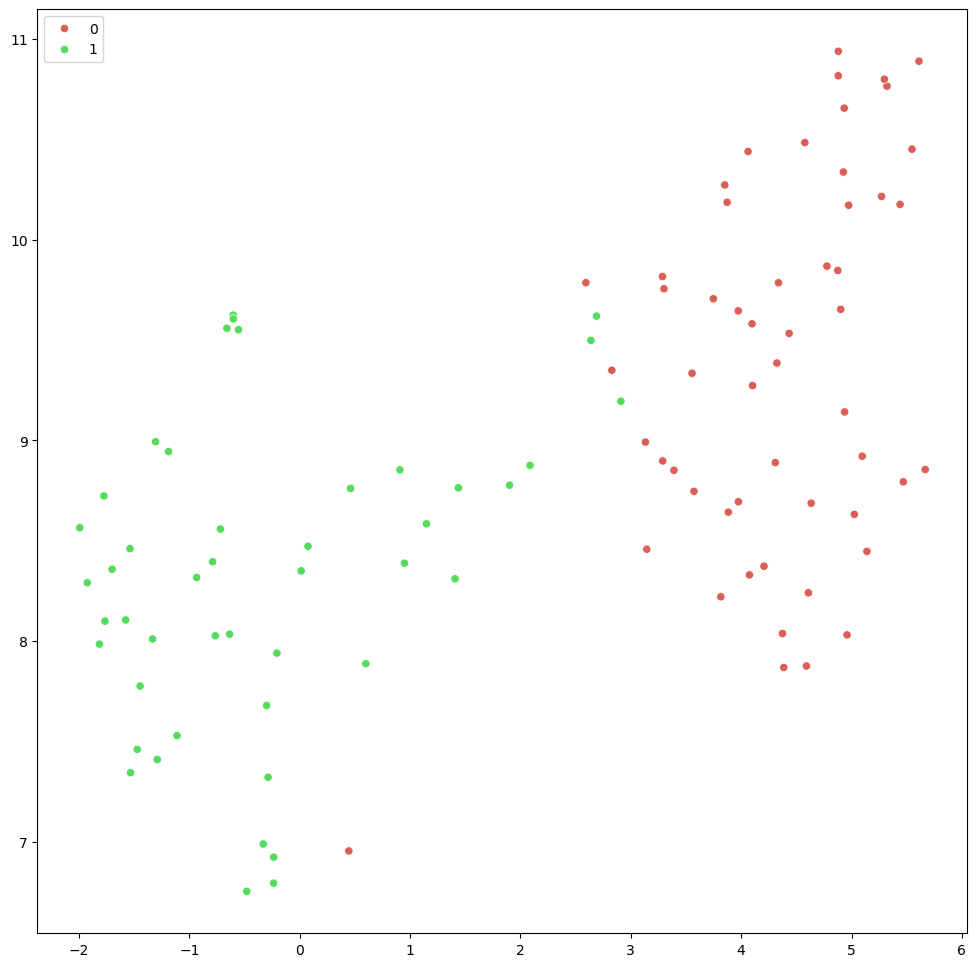

In [33]:
import seaborn as sns
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue = y_test, palette = sns.hls_palette(3), legend = 'full');

#### Classifying using these features

In [34]:
from sklearn.neighbors import KNeighborsClassifier
import pickle

# extract features from the training subset:
df_train = model_FE.predict(X_train)
knn_DL = KNeighborsClassifier(n_neighbors=2) # load the model
knn_DL.fit(df_train,y_train) # fit the model using training data
y_test_pred_DL = knn_DL.predict(df_test) # model prediction of test data

25/25 [==============================] - 4s 163ms/step


In [36]:
from sklearn.metrics import confusion_matrix

Text(0.5, 1.0, 'KNN trained DL features classification')

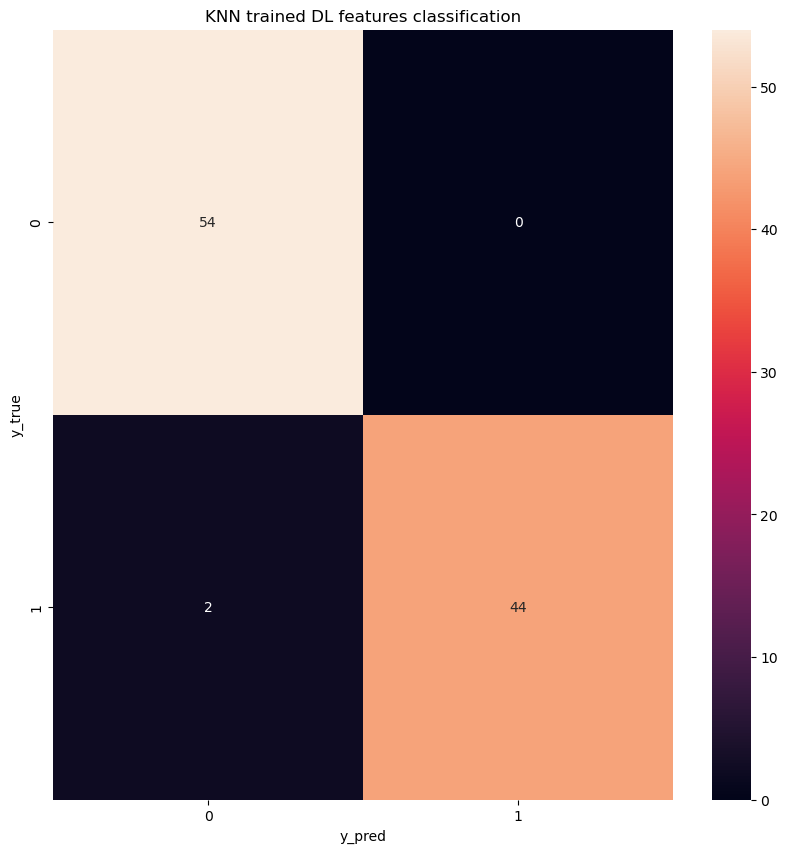

In [37]:
cm_DL = confusion_matrix(y_test, y_test_pred_DL)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_DL,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN trained DL features classification')